In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sbn
%matplotlib inline

In [4]:
df = pd.read_table("train.tsv")

In [5]:
df.head()

,item_id,Seller,Actors,Actual Color,Artist ID,Aspect Ratio,Color,Genre ID,ISBN,Item Class ID,...,Product Name,Product Short Description,Publisher,Recommended Location,Recommended Room,Recommended Use,Short Description,Synopsis,actual_color,tag
0,0,Circuit City,NaN,Multicolor,NaN,NaN,NaN,NaN,NaN,1,...,Cyberpower Metered ATS PDU 200-240V 20A 1U 10-...,NaN,NaN,NaN,NaN,NaN,"The CyberPower PDU20MHVT10AT, a 10-outlet 1U r...",NaN,NaN,[4483]
1,1,NaN,NaN,Black,NaN,NaN,NaN,NaN,NaN,1,...,Peerless SmartMount SF650P Universal Flat Wall...,Peerless SmartMount SF650P Universal Flat Wall...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[581514]
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,"DAYTON 31EH66 Control Transformer Fused,4.02H ...",NaN,NaN,NaN,NaN,NaN,short description is not available,NaN,NaN,[4483]
3,3,Pcrush,NaN,Multicolor,NaN,NaN,NaN,NaN,NaN,19,...,STEREN-CUSTOM INSTALL 255-047 STEREN MINI TO R...,NaN,NaN,NaN,NaN,NaN,<p>Steren 3.5mm to RCA Y-Cable 255-047</p><p>1...,NaN,NaN,[4537]
4,4,Walmart.com,NaN,Black,NaN,NaN,NaN,NaN,NaN,19,...,"LG 47LN5700 47"" 1080p 120Hz LED (3.17"" ultra-s...",NaN,NaN,NaN,NaN,NaN,"The LG 42LN5700 47"" 1080p 120Hz LED HDTV is a ...",NaN,NaN,"[1229817, 1229821]"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10593 entries, 0 to 10592
Data columns (total 23 columns):
item_id                      10593 non-null int64
Seller                       5024 non-null object
Actors                       243 non-null object
Actual Color                 4799 non-null object
Artist ID                    88 non-null float64
Aspect Ratio                 1039 non-null object
Color                        17 non-null object
Genre ID                     87 non-null float64
ISBN                         258 non-null float64
Item Class ID                10578 non-null object
Literary Genre               134 non-null object
MPAA Rating                  871 non-null object
Product Long Description     10584 non-null object
Product Name                 10584 non-null object
Product Short Description    4195 non-null object
Publisher                    189 non-null object
Recommended Location         112 non-null object
Recommended Room             5 non-null object


In [7]:
df[df['Product Name'].isnull()]['tag']

2801            [4537]
3926            [4483]
4019          [106546]
4070            [4483]
6129            [4483]
6392    [4537, 581514]
7361          [106546]
7766            [4483]
9474            [4483]
Name: tag, dtype: object

### Remove completely empty records
Apparently some records only contain the shelf, without giving out any other info. 
It's safe to say that they are completely useless.

EDIT: Maybe we'll do it later.

In [8]:
# df = df[-df['Product Name'].isnull()]

### Exploring tags (aka labels)

In [9]:
# Now we extract and straighten the tags (shelves) 
# to see how they are distributed.
# This will create a simple list of occurrences, 
# Without any info on the items.
def straighten_tags(df_tags):
    mylist = []
    for tags in df_tags:
            mylist += tags.strip(']').strip('[').split(',')
    return mylist

In [10]:
straight_list = straighten_tags(df['tag'])

In [11]:
straight_list = [int(s) for s in straight_list]
straight_list = np.array(straight_list)

In [12]:
s_tags = pd.Series(straight_list)

In [13]:
s_tags.describe()

count    1.261700e+04
mean     4.214179e+05
std      6.498953e+05
min      4.457000e+03
25%      4.537000e+03
50%      1.065460e+05
75%      5.815140e+05
max      3.304195e+06
dtype: float64

In [14]:
s_tags.median()

106546.0

In [15]:
s_tags.mode()

0    4537
dtype: int64

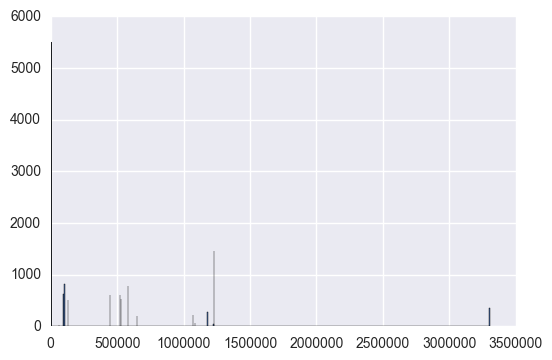

In [16]:
s_tags.hist(bins=1000)

In [17]:
print(len(s_tags.unique()), s_tags.unique())

32 [   4483  581514    4537 1229817 1229821 3304195 1180168  447913  522484
 1070524   95987  127175  529295  106546 1229825 1229820    5065    4538
  650659    4536 1225174 1071165 1229819   62056 1084835 1229818  648819
    4457 1085065  133270  645319 1229823]


In [18]:
s_tags.value_counts()

4537       2803
4483       2115
106546      827
581514      772
1229821     763
95987       619
447913      608
522484      603
529295      520
127175      510
1229817     389
3304195     345
1180168     271
4538        250
4536        229
650659      195
1229820     175
1070524     169
5065         80
1229819      60
1225174      53
1071165      52
1085065      51
1229825      50
62056        29
4457         22
1084835      21
1229818      16
648819       11
1229823       3
645319        3
133270        3
dtype: int64

## Multi-label classification

This is the correct name of the task we are trying to perform. 
The best way to handle this is to have a binary array of length
'\# of labels', where the 1s mark the labels associated with a record. 

We have to handle 32 labels in total, so we will have a 32-element binary array.

In [19]:
import json

In [20]:
df['label'] = df.tag.apply(lambda x: json.loads(x))

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
blabels = MultiLabelBinarizer().fit_transform(df['label'])

In [22]:
blabels.shape

(10593, 32)

In [131]:
df['blabel'] = pd.Series(list(blabels))

### HTML parsing
To extract some information from the data we have to use the description in HTML. 
We have to remove all the HTML tags.

In [24]:
from bs4 import BeautifulSoup

In [25]:
# clean_html(df['Product Long Description'][0])
soup = BeautifulSoup(df['Product Long Description'][0], "lxml")

In [26]:
print(soup.get_text(separator="\n"))

Interfaces/Ports
Network (RJ-45):   Yes
General Information
Product Type:   PDU
Manufacturer Part Number:   PDU20MHVT10AT
Manufacturer Website Address:   http://www.cyberpowersystems.com
Manufacturer:   CyberPower Systems, Inc
Product Model:   PDU20MHVT10AT
Product Name:   PDU20MHVT10AT Metered ATS PDU 200-240V 20A 1U 10-Outlets (2) L6-20P
Product Series:   Metered
Brand Name:   CyberPower
Management
Management:    
HTTP
 
TCP/IP
 
UDP
 
DHCP
 
SNMP
 
SNMPv3
 
IPv4
 
IPv6
 
NTP
 
SMTP
 
Miscellaneous
Package Contents
 
PDU20MHVT10AT Metered ATS PDU 200-240V 20A 1U 10-Outlets (2) L6-20
 
Mounting Brackets (1 Set)
 
Cord Retention Tray
 
Cord Organizers
 
User Manual
 
Compatibility
 
Data Centers
 
Servers
 
Network Devices
 
Telecom Equipment
 
CyberPower UPS's:
 
PR5000LCDRTXL5U
 
PR6000LCDRTXL5U
 
OL6000RT3U
 
OL6000RT3UTF
 
OL8000RT3UTF
 
OL10000RT3UTF
 
Certifications & Standards
 
UL60950-1 Certified by ETL (USA)
 
CSA C22.2(Canada)
 
FCC Class A
 
Green Compliant
 Yes
Green Compl

### TF-IDF with scikit-learn
See http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [148]:
# we have to remove the records with only NaN in the description
df = df[-df['Product Name'].isnull()]

In [149]:
soup = BeautifulSoup(df['Product Long Description'][0], "lxml")
# print(soup.get_text(separator="\n"))

In [150]:
soups = [BeautifulSoup(item, "lxml").get_text(separator="\n") for item in df['Product Long Description']]

/home/guzzo/anaconda3/envs/py3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "https://images.tradeservice.com/HFQM9GWTE1O3PHYL/ATTACHMENTS/DIR100058/THHN.pdf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [151]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(soups)
X_train_counts.shape

(10584, 39573)

In [152]:
# Check the absolute frequency of a word
count_vect.vocabulary_.get(u'electric')

14814

In [153]:
# Perform actual TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tfidf.shape

(10584, 39573)

In [154]:
print(X_train_tfidf.shape)

(10584, 39573)


#### Training a classifier
Follow the sklearn tutorial using Naive Bayes

In [155]:
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB().fit(X_train_tfidf, df.blabel)

In [156]:
# testing
from sklearn.decomposition import PCA
X = PCA(n_components=2).fit_transform(X_train_tfidf.toarray())

In [157]:
X.shape

(10584, 2)

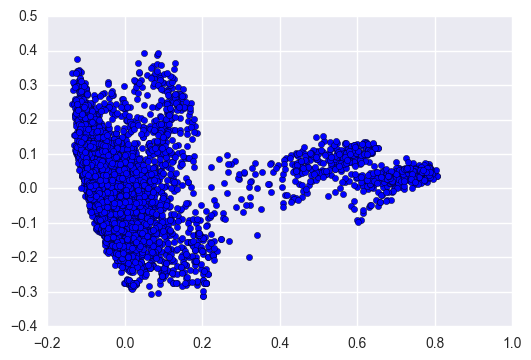

In [158]:
plt.scatter(X[:,0],X[:,1])

In [159]:
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB()

In [176]:
from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier()
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
y = np.array(df['blabel'].tolist())
print(X_train_tfidf.shape,\
y.shape) #, dtype="|S6")
X_train, X_test = X_train_tfidf[:8000], X_train_tfidf[8000:]
y_train, y_test = y[:8000], y[8000:]

(10584, 39573) (10584, 32)


In [177]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=-1)

In [191]:
y_pred = clf.predict(X_test)

In [216]:
def f1_score(labels, predictions):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    for i in range(len(labels)):
        if (predictions[i] == labels[i]).all():
            tp += len(predictions[i][predictions[i] == 1])
            tn += len(predictions[i][predictions[i] == 0])
        else:
            for j in labels[i, predictions[i] != labels[i]]:
                if y_pred[i,j] == 1:
                    fp += 1
                else:
                    fn += 1
    accuracy = (tp + tn)/len(labels)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = 2*precision * recall / (precision + recall)
    return accuracy, precision, recall, f1

In [218]:
f1_score(y_test, y_pred)

# len(y_pred[0][y_pred[0] == 0])

(14.823529411764707, 0.984375, 0.41028980788016933, 0.5791772006435303)

### Quick calculation without any tuning

In [219]:
clf.fit(X_train_tfidf, y)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=-1)

In [ ]:
y_